Author: Fajar Ari Nugroho_1494037162101-489

Proyek Kedua : Membuat Model Machine Learning dengan Data Time Series

#Prepare Dataset

Proyek pembuatan model kali ini menggunakan data <a href="https://www.kaggle.com/datasets/shaneysze/new-york-city-daily-temperature-18692021?select=nyc_temp_1869_2021.csv"> "New York City Daily Temperature From 1869 to 2021 Dataset"</a> yang berasal dari Kaggle. Proyek ini dilakukan untuk bisa membuat model Machine Learning yang ke depannya dapat digunakan untuk bisa melakukan prediksi (forecast). Langkah pertama, yaitu melakukan instalasi kaggle, load data, dan merubah format dataset .csv menjadi dataframe.

## Collect Data

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fajararinugroho","key":"9ed0265ee6410a8e449b20bfb4a0c196"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [4]:
! kaggle datasets download -d shaneysze/new-york-city-daily-temperature-18692021 -f nyc_temp_1869_2021.csv

100% 517k/517k [00:01<00:00, 472kB/s]
100% 517k/517k [00:01<00:00, 472kB/s]


In [5]:
! unzip nyc_temp_1869_2021.csv.zip

Archive:  nyc_temp_1869_2021.csv.zip
  inflating: nyc_temp_1869_2021.csv  


## Exploratory Data Analysis

In [6]:
import pandas as pd

df = pd.read_csv('/content/nyc_temp_1869_2021.csv', encoding= 'unicode_escape')
df

,Unnamed: 0,MM/DD/YYYY,YEAR,MONTH,DAY,TMAX,TMIN
0,0,1869-01-01,1869,1,1,-17.0,-72.0
1,1,1869-01-02,1869,1,2,-28.0,-61.0
2,2,1869-01-03,1869,1,3,17.0,-28.0
3,3,1869-01-04,1869,1,4,28.0,11.0
4,4,1869-01-05,1869,1,5,61.0,28.0
...,...,...,...,...,...,...,...
55629,55629,2021-04-30,2021,4,30,217.0,78.0
55630,55630,2021-05-01,2021,5,1,183.0,56.0
55631,55631,2021-05-02,2021,5,2,278.0,133.0
55632,55632,2021-05-03,2021,5,3,189.0,111.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55634 entries, 0 to 55633
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  55634 non-null  int64  
 1   MM/DD/YYYY  55634 non-null  object 
 2   YEAR        55634 non-null  int64  
 3   MONTH       55634 non-null  int64  
 4   DAY         55634 non-null  int64  
 5   TMAX        55634 non-null  float64
 6   TMIN        55634 non-null  float64
dtypes: float64(2), int64(4), object(1)
memory usage: 3.0+ MB


Data yang akan digunakan terdiri dari 55634 data, tidak ada data null, tetapi untuk kolom `MM/DD/YYYY` masih bertipe object, sehingga harus diubah ke bentuk datetime, dan akan dilakukan perhitungan rata-rata temperatur `mean()`. Untuk nilai temperatur pun masih dalam skala (x10), sehingga untuk mendapatkan nilai asli, dilakukan pembagian 10. Dilakukan juga eliminasi kolom `Unnamed`, `YEAR`, `MONTH`, `DAY`, `TMAX`, dan `TMIN`.

In [8]:
df['TMAX'] /= 10
df['TMIN'] /= 10
df['MEAN'] = df[['TMAX', 'TMIN']].astype(float).mean(axis=1)
df['MM/DD/YYYY'] = pd.to_datetime(df['MM/DD/YYYY'])

In [9]:
df = df.rename(columns={
    "MM/DD/YYYY":"date",
    "MEAN":"temp_avg"})
df.drop(['Unnamed: 0', 'YEAR', 'MONTH', 'DAY', 'TMAX', 'TMIN'], axis=1, inplace=True)
df.tail(5)

,date,temp_avg
55629,2021-04-30,14.75
55630,2021-05-01,11.95
55631,2021-05-02,20.55
55632,2021-05-03,15.00
55633,2021-05-04,16.95


Selanjutnya akan dilakukan visualisasi untuk melihat gambaran plot temperaturnya.

date        datetime64[ns]
temp_avg           float64
dtype: object

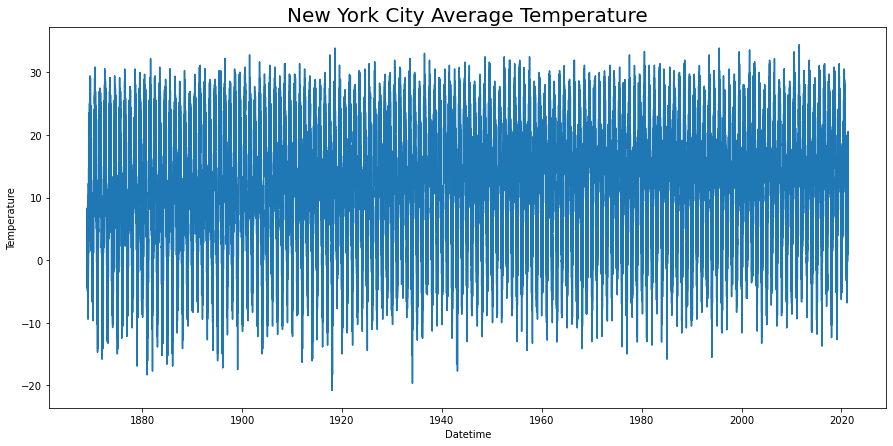

In [10]:
import matplotlib.pyplot as plt

dates = df['date'].values
temp = df['temp_avg'].values

plt.figure(figsize=(15,7))
plt.plot(dates, temp)

plt.title('New York City Average Temperature',
          fontsize=20)
plt.ylabel('Temperature')
plt.xlabel('Datetime')
df.dtypes

## Data Preprocessing

Untuk mendapatkan data yang konvergen dan berdistribusi normal, maka perlu dilakukan proses `standardisasi` terlebih dahulu melalui proses berikut:

In [11]:
suhu = df['temp_avg'].values
suhu

array([-4.45, -4.45, -0.55, ..., 20.55, 15.  , 16.95])

In [12]:
suhu_new = suhu.reshape(-1, 1)

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()                            
scaler.fit(suhu_new)
suhu = scaler.transform(suhu_new)

In [14]:
temp = suhu.flatten()
temp

array([-1.70393081, -1.70393081, -1.30637941, ...,  0.84447556,
        0.27872935,  0.47750504])

Setelah dirasa data sudah siap, dilakukan proses pembagian data dengan ketentuan 80:20 untuk train data dan test/validation data.

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(temp, dates, train_size=0.8, test_size=0.2, shuffle=False)

print('Total Train: ',len(X_train))
print('Total Validation: ',len(X_valid))

Total Train:  44507
Total Validation:  11127


Sebelum melakukan pemodelan, dilakukan perubahan format data agar dapat diterima oleh model melalui fungsi berikut:

In [16]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

# Machine Learning Modeling

Untuk proyek ini, dipilih menggunakan model Sequential, menggunakan layer LSTM, dan digunakan layer Dropout untuk mencegah jika terjadi model yang overfitting seperti berikut.

In [17]:
from keras.layers import LSTM, Dense, Dropout

train_set = windowed_dataset(X_train, window_size=60, batch_size=100, shuffle_buffer=1000)
valid_set = windowed_dataset(X_valid, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(30, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(1),
])

Dilakukan perhitungan nilai MAE dan pembuatan fungsi callback sebelum model kita training dengan tujuan ketika training mencapai nilai yang diinginkan proses akan berhenti sehingga mempersingkat waktu. Model yang bagus akan menghasilkan nilai mae sebesar <10% dari total data

In [18]:
threshold_mae = (temp.max() - temp.min()) * 10/100
print(threshold_mae)

0.5637074882476562


In [19]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
      print('\nEpoch', epoch, '\nGreat!, MAE of your model has reach <10% of data scale', 'training is already stop!')
      self.model.stop_training = True

In [20]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
)

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Model telah siap ditraining

In [21]:
tf.keras.backend.set_floatx('float64')

history = model.fit(
    train_set,
    validation_data=valid_set,
    epochs=100,
    callbacks = [myCallback()]
)

Epoch 1/100
445/445 [==============================] - 35s 55ms/step - loss: 0.3487 - mae: 0.7261 - val_loss: 0.2409 - val_mae: 0.5814
Epoch 2/100
444/445 [============================>.] - ETA: 0s - loss: 0.2217 - mae: 0.5408
Epoch 1 
Great!, MAE of your model has reach <10% of data scale training is already stop!
445/445 [==============================] - 12s 27ms/step - loss: 0.2216 - mae: 0.5407 - val_loss: 0.1497 - val_mae: 0.4359


Dari hasil training, didapatkan bahwa pada `Epoch ke-1` model yang dibuat sudah menunjukkan nilai mae sebesar < 10% dari skala data kita

# Evalution

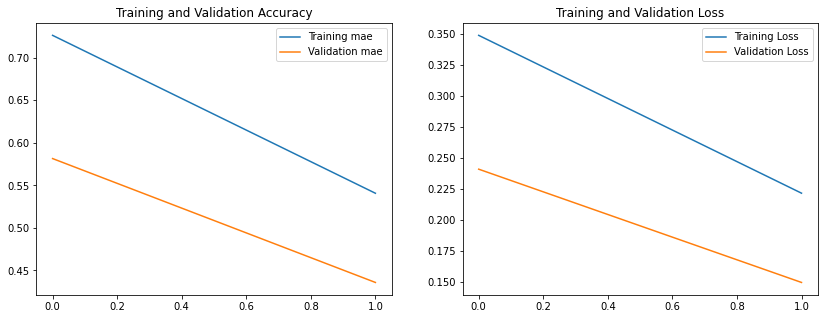

In [22]:
import matplotlib.image as mpimg
%matplotlib inline

plt.figure(figsize=(14, 5))
# Accuracy Plot
plt.subplot(1, 2, 1)
mae = history.history['mae']
val_mae = history.history['val_mae']
epochs = range(len(mae))
plt.plot(epochs, mae, label='Training mae')
plt.plot(epochs, val_mae, label='Validation mae')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')

# Loss Plot
plt.subplot(1, 2, 2)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(mae))
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()